In [1]:
import os
import itertools
from collections import Counter
import statistics
import warnings
warnings.filterwarnings("ignore", message=".*set_ticklabels.*")

from tqdm import tqdm

import numpy as np
import pandas as pd

from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR

from sklearn.metrics import make_scorer, mean_squared_error
from scipy.stats import pearsonr
from scipy import stats
from statsmodels.stats.multitest import multipletests
from sklearn.utils import shuffle
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor


import seaborn as sns
import matplotlib.pyplot as plt

import sys
sys.path.insert(1, '../')
from utils import mixup, write_pickled_object, cohen_d, aggregate_ranks
from utils import get_stats as get_stats_best
from utils import ProteinFeatureSelector, MeanCenterer

/orcd/pool/005/hmbaghda/miniforge3/envs/metastatic_potential/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_path = '/home/hmbaghda/orcd/pool/metastatic_potential/'
random_state = 42

n_cores = 30
os.environ["OMP_NUM_THREADS"] = str(n_cores)
os.environ["MKL_NUM_THREADS"] = str(n_cores)
os.environ["OPENBLAS_NUM_THREADS"] = str(n_cores)
os.environ["VECLIB_MAXIMUM_THREADS"] = str(n_cores)
os.environ["NUMEXPR_NUM_THREADS"] = str(n_cores)

In [3]:
res = pd.read_csv(os.path.join(data_path, 'interim', 
                               'pipeline_model_selection_proteomics_individual.csv'), index_col = 0)
model_types = ['Ridge', 'ElasticNet', 'Lasso', 'PLS', 'SVR_linear',
               'SVR_poly', 'SVR_rbf', 'KNN', 'RFR']
res.model_type = pd.Categorical(res.model_type, categories = model_types, ordered = True)

First, let's get a rank-ordering across our two test metrics, MSE and Pearson correlation. For each model, we first aggregate by median value across folds. Then, we calculate the rank of the model (lower rank = better performance) for each test metric. Finally, we aggregate across test metrics using the stringent maximum rank per model -- what is the worse the model performed.

In [4]:
rank_order = aggregate_ranks(
    opt_res=res.groupby('model_type', observed = True)[['test_mse', 'test_corr']].median().reset_index(), 
    feature_col = 'model_type', 
    metric_directions = {
        'test_mse': 'lower', 
        'test_corr': 'higher'
    },
    method = 'median'
)
model_order = rank_order['model_type'].tolist()
rank_order

,model_type,test_mse,test_corr,test_mse_rank,test_corr_rank,consensus_score,consensus_rank
0,Ridge,2.712891,0.396133,2.0,1.0,1.5,1.0
1,SVR_poly,2.663329,0.343643,1.0,3.0,2.0,2.0
2,SVR_linear,2.830099,0.346929,4.0,2.0,3.0,3.0
3,KNN,2.801836,0.319546,3.0,5.0,4.0,4.0
4,SVR_rbf,2.886395,0.326116,5.0,4.0,4.5,5.0
5,RFR,2.936639,0.274288,6.0,6.0,6.0,6.0
6,PLS,3.007646,0.260119,7.0,7.0,7.0,7.0
7,ElasticNet,3.221013,0.170680,8.0,8.0,8.0,8.0
8,Lasso,3.287038,0.144283,9.0,9.0,9.0,9.0


Let's compare each models performance with identified best hyperparameters for a specific fold:

In [5]:
import copy
res_stats = pd.DataFrame(columns = ['comparison', 'pval_corr', 'cohen_d_corr', 
                                   'pval_mse', 'cohen_d_mse'])
mod_combs = itertools.combinations((res.model_type.unique()), 2)

for mc in copy.deepcopy(mod_combs):
    a = res[res.model_type == mc[0]]
    b = res[res.model_type == mc[1]]
    
    pval_corr = stats.mannwhitneyu(a.test_corr[~np.isnan(a.test_corr)],b.test_corr[~np.isnan(b.test_corr)]).pvalue
    cd_corr = cohen_d(a.test_corr,b.test_corr)

    pval_mse = stats.mannwhitneyu(a.test_mse[~np.isnan(a.test_mse)],b.test_mse[~np.isnan(b.test_mse)]).pvalue
    cd_mse = cohen_d(a.test_mse,b.test_mse)
    
    res_stats.loc[res_stats.shape[0], :] = [mc, pval_corr, cd_corr, pval_mse, cd_mse]
    
_, fdr_corr, _, _ = multipletests(res_stats.pval_corr.values, method='fdr_bh')
_, fdr_mse, _, _ = multipletests(res_stats.pval_mse.values, method='fdr_bh')
res_stats['fdr_corr'] = fdr_corr
res_stats['fdr_mse'] = fdr_mse
res_stats.to_csv(os.path.join(data_path, 'processed', 'transcriptomics_comparison_stats.csv'))
res_stats

,comparison,pval_corr,cohen_d_corr,pval_mse,cohen_d_mse,fdr_corr,fdr_mse
0,"(SVR_linear, PLS)",0.212294,0.580263,0.161972,-0.708628,0.402241,0.583101
1,"(SVR_linear, Ridge)",0.677585,-0.15609,0.909722,-0.06177,0.786873,0.992424
2,"(SVR_linear, Lasso)",0.0022,1.882681,0.075662,-0.794084,0.026396,0.583101
3,"(SVR_linear, ElasticNet)",0.031209,1.024433,0.161972,-0.553095,0.140441,0.583101
4,"(SVR_linear, SVR_poly)",0.96985,-0.007108,0.96985,0.063824,0.96985,0.99756
5,"(SVR_linear, SVR_rbf)",0.520523,0.42793,0.791337,-0.093483,0.694031,0.918972
6,"(SVR_linear, RFR)",0.121225,0.831828,0.520523,-0.309364,0.335699,0.892325
7,"(SVR_linear, KNN)",0.623176,0.381971,0.73373,-0.153475,0.747811,0.918972
8,"(PLS, Ridge)",0.053903,-0.793576,0.10411,0.644201,0.176408,0.583101
9,"(PLS, Lasso)",0.019964,1.457588,0.791337,-0.114396,0.126804,0.918972


In [6]:
res_stats[res_stats.fdr_corr <= 0.1]

,comparison,pval_corr,cohen_d_corr,pval_mse,cohen_d_mse,fdr_corr,fdr_mse
2,"(SVR_linear, Lasso)",0.0022,1.882681,0.075662,-0.794084,0.026396,0.583101
15,"(Ridge, Lasso)",0.0022,2.150187,0.121225,-0.731961,0.026396,0.583101
22,"(Lasso, SVR_poly)",0.000944,-2.033685,0.053903,0.895083,0.026396,0.583101


In [7]:
res_stats[res_stats.fdr_mse <= 0.1]

,comparison,pval_corr,cohen_d_corr,pval_mse,cohen_d_mse,fdr_corr,fdr_mse


Just as in the transcriptomics dataset, there are no significant differences in model performance by MSE. While Pearson does have significant differences, it's only between top and bottom ranking models. Since we proceed with top 3 models anyways, this has no effect.

To reduce the multiple testing burden, let's also subset to our top 3 models by rank, and see whether there are any significant differences in this case.

In [8]:
res_sub = res[res.model_type.isin(model_order[:3])].copy()

res_sub_stats = pd.DataFrame(columns = ['comparison', 'pval_corr', 'cohen_d_corr', 
                                   'pval_mse', 'cohen_d_mse'])
mod_combs_sub = itertools.combinations((res_sub.model_type.unique()), 2)

for mc in mod_combs_sub:
    a = res_sub[res_sub.model_type == mc[0]]
    b = res_sub[res_sub.model_type == mc[1]]
    
    pval_corr = stats.mannwhitneyu(a.test_corr,b.test_corr).pvalue
    cd_corr = cohen_d(a.test_corr,b.test_corr)
    
    pval_mse = stats.mannwhitneyu(a.test_mse,b.test_mse).pvalue
    cd_mse = cohen_d(a.test_mse,b.test_mse)
    
    res_sub_stats.loc[res_sub_stats.shape[0], :] = [mc, pval_corr, cd_corr, pval_mse, cd_mse]
    
_, fdr_corr, _, _ = multipletests(res_sub_stats.pval_corr.values, method='fdr_bh')
_, fdr_mse, _, _ = multipletests(res_sub_stats.pval_mse.values, method='fdr_bh')
res_sub_stats['fdr_corr'] = fdr_corr
res_sub_stats['fdr_mse'] = fdr_mse
# res_sub_stats.to_csv(os.path.join(data_path, 'processed', 'transcriptomics_comparison_stats.csv'))
res_sub_stats

,comparison,pval_corr,cohen_d_corr,pval_mse,cohen_d_mse,fdr_corr,fdr_mse
0,"(SVR_linear, Ridge)",0.677585,-0.15609,0.909722,-0.06177,0.96985,0.96985
1,"(SVR_linear, SVR_poly)",0.96985,-0.007108,0.96985,0.063824,0.96985,0.96985
2,"(Ridge, SVR_poly)",0.791337,0.162596,0.96985,0.128541,0.96985,0.96985


We can see that even here, none of our models have significant differences in performance. 

/tmp/ipykernel_960941/3550830426.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data = res, x = 'model_type', y = 'test_' + metric_type, ax = ax[i],
/tmp/ipykernel_960941/3550830426.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data = res, x = 'model_type', y = 'test_' + metric_type, ax = ax[i],


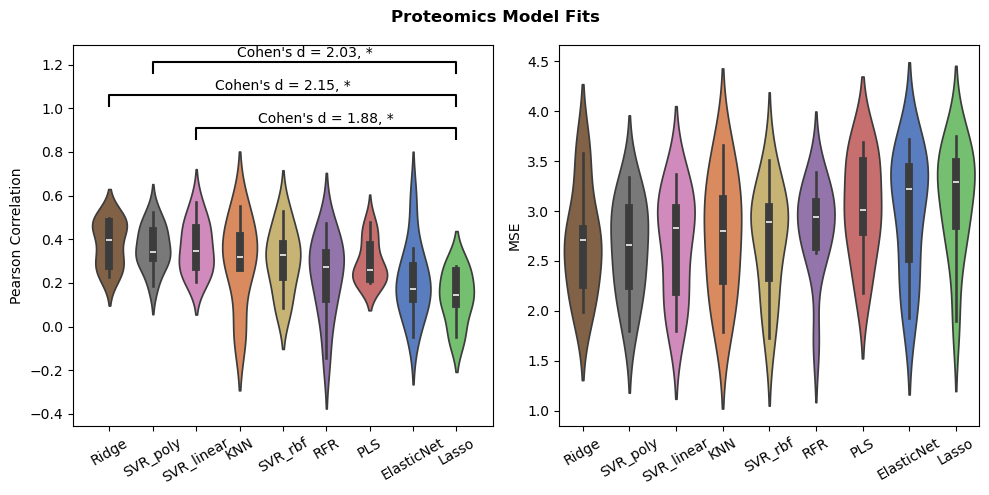

In [9]:
fig, ax = plt.subplots(ncols = 2, figsize = (10,5))

metric_types = ['corr', 'mse']
mmap = dict(zip(metric_types, ['Pearson Correlation', 'MSE']))
# order_map = dict(zip(metric_types, [corr_order, mse_order]))
order_map = dict(zip(metric_types, [model_order, model_order]))

palette = dict(zip(sorted(res.model_type.unique()), sns.color_palette("muted")))

for i, metric_type in enumerate(metric_types):
    # sort by mean of metric
    res.model_type = pd.Categorical(res.model_type, categories = order_map[metric_type], 
                               ordered = True)
    
    
    sns.violinplot(data = res, x = 'model_type', y = 'test_' + metric_type, ax = ax[i], 
                  palette = palette)#,
#                    fill = False, inner = None)
    
#     sns.boxplot(data=res, x = 'model_type', y = 'test_' + metric_type, 
#                 width=0.1, 
#                 color="black", showcaps=False, boxprops={'facecolor':'none'}, 
#                 whiskerprops={'linewidth':0.5}, ax = ax[i])
#     sns.stripplot(data=res, x = 'model_type', y = 'test_' + metric_type, 
#                   alpha=0.5, jitter=True, dodge=True, ax = ax[i], color = 'black')
    
    ax[i].set_xlabel('')
    ax[i].set_ylabel(mmap[metric_type])
    
    xlabels = [x._text for x in ax[i].get_xticklabels()]
    x_pos = dict(zip(xlabels, ax[i].get_xticks()))
    y, h = ax[i].get_ylim()[1], 0.05
    
    ax[i].set_xticklabels(xlabels, 
                          rotation=30, 
                         ha = 'center')
    
    sig_counter = 0
    for j, (comp1, comp2) in enumerate(mod_combs):#(itertools.combinations(xlabels, 2)):
        x_mid = (x_pos[comp1] + x_pos[comp2]) / 2
        
        fdr = res_stats[res_stats.comparison == (comp1, comp2)]['fdr_' + metric_type].values[0]
        cd = abs(res_stats[res_stats.comparison == (comp1, comp2)]['cohen_d_' + metric_type].values[0])
        
        significance = "N.S."
        if fdr <= 1e-4:
            significance = "****"
        elif fdr <= 0.001:
            significance = "***"
        elif fdr <= 0.01:
            significance = "**"
        elif fdr <= 0.1:
            significance = "*"
        
        if significance != 'N.S.':
            y_pos = y+(sig_counter*0.15)
            ax[i].plot([x_pos[comp1], x_pos[comp1], x_pos[comp2], x_pos[comp2]], 
                       [y_pos, y_pos+h, y_pos+h, y_pos], 
                       lw=1.5, c='black')
            y_pos*=1.01
            ax[i].text(x_mid, y_pos + h, f"Cohen's d = {cd:.2f}, " + significance, 
                    ha='center', va='bottom', fontsize=10)
            sig_counter += 1
            

#     ax[i].grid(axis='y', linestyle='--', alpha=0.7)

# fig.suptitle('Proteomics Model Fits')
fig.suptitle('Proteomics Model Fits',
    fontweight='bold',  # Makes the text bold
)


fig.tight_layout()
plt.savefig(os.path.join(data_path, 'figures', 'all_models_proteomics.png'), 
            dpi=300, 
            bbox_inches="tight")  


For each metric (panels), violin plots are ordered by the best performing rank across folds. Each fold has the best model selected using optuna hyperparameter tuning. We observe the following: 
- there are no significant differences in any of the model performance for both correlation and MSE
- relative model performance is consistent between correlation and MSE, with SVMs performing best (with the exception of Ridge regression).

# Consensus model

Here, we simply want to assess consensus proteomics models' predictive performance, particularly relative to transcriptomics. Thus, we'll take the top three models by each metric, and see how they perform as compared to the consensus model identified for transcriptomics (in [notebook A/03]( ../A_rna_prediction/03_predict_transcriptomics.ipynb)). Between Pearson correlation and MSE, the top 3 performing models are:
- Ridge
- SVR linear
- SVR poly

In [10]:
def p_max(x):
    counts = Counter(x)
    most_common_count = counts.most_common(1)[0][1]
    return most_common_count / len(x)

In [11]:
X = pd.read_csv(os.path.join(data_path, 'processed',  'expr_protein.csv'), index_col = 0).values
y = pd.read_csv(os.path.join(data_path, 'processed', 'metastatic_potential_protein.csv'), index_col = 0)['mean'].values.ravel()
X.shape


(248, 10969)

Let's get the consensus model for ridge:

In [12]:
model_type = 'Ridge'
print(model_type)
res_model = res[res.model_type == model_type]

n_features_best = []
alpha_best = []
for k,bp in enumerate(res_model.best_params):
    n_features = int(bp.split(', ')[0].split(': ')[1])
    alpha = float(bp.split(', ')[1].split(': ')[1][:-1])
    n_features_best.append(n_features)
    alpha_best.append(alpha)
    
    print('Fold: {}, features: {}, alpha: {:4f}'.format(k, n_features, alpha))

n_features_best = statistics.mode(n_features_best) if p_max(n_features_best)>=0.5 else int(round(np.mean(n_features_best)))
alpha_best = np.mean(alpha_best)
print('The consensus model has features: {}, alpha: {:.4f}'.format(n_features_best, alpha_best))

    
best_steps = [
    ("feature_reduction", ProteinFeatureSelector(n_features = n_features_best)),
    ("mean_centering", MeanCenterer()),
]
best_steps.append(("model", Ridge(
    alpha  = alpha_best,
    random_state=random_state,
#     n_jobs=n_cores
)))
best_pipeline_ridge = Pipeline(best_steps)
best_pipeline_ridge


Ridge
Fold: 0, features: 5000, alpha: 99.732668
Fold: 1, features: 5000, alpha: 99.732668
Fold: 2, features: 5000, alpha: 99.732668
Fold: 3, features: 5000, alpha: 99.732668
Fold: 4, features: 1000, alpha: 99.753141
Fold: 5, features: 5000, alpha: 99.732668
Fold: 6, features: 5000, alpha: 99.732668
Fold: 7, features: 5000, alpha: 99.732668
Fold: 8, features: 5000, alpha: 99.732668
Fold: 9, features: 5000, alpha: 99.732668
The consensus model has features: 5000, alpha: 99.7347


,steps,"[('feature_reduction', ...), ('mean_centering', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,method,'top_residuals'
,n_features,5000
,alpha,99.73471542509238
,fit_intercept,True
,copy_X,True
,max_iter,None
,tol,0.0001


In [13]:
model_type = 'SVR_linear'
print(model_type)

res_model = res[res.model_type == model_type]

n_features_best = []
C_best = []
epsilon_best = []
for k, bp in enumerate(res_model.best_params):
    n_features = int(bp.split(', ')[0].split(': ')[1])
    C = float(bp.split(', ')[1].split(': ')[1])
    epsilon = float(bp.split(', ')[2].split(': ')[1][:-1])
    
    n_features_best.append(n_features)
    C_best.append(C)
    epsilon_best.append(epsilon)    
    
    print('Fold: {}, features: {}, C: {:4f}, epsilon: {:.4f}'.format(k, n_features, C, epsilon))

n_features_best = statistics.mode(n_features_best) if p_max(n_features_best)>=0.5 else int(round(np.mean(n_features_best)))
C_best = np.mean(C_best)
epsilon_best = np.mean(epsilon_best)


print('The consensus model has features: {}, C: {:4f}, epsilon: {:.4f}'.format(n_features_best, C_best, epsilon_best))

    
best_steps = [
    ("feature_reduction", ProteinFeatureSelector(n_features = n_features_best)),
    ("mean_centering", MeanCenterer()),
]
best_steps.append(("model", SVR(
    kernel='linear',
    C=C_best,
    epsilon=epsilon_best)
))
best_pipeline_svr_linear = Pipeline(best_steps)

write_pickled_object(best_pipeline_svr_linear, 
                    os.path.join(data_path, 'processed', 'best_model_proteomics_svrlinear.pickle'))

best_pipeline_svr_linear

SVR_linear
Fold: 0, features: 5000, C: 0.025831, epsilon: 0.4607
Fold: 1, features: 5000, C: 0.011718, epsilon: 0.4344
Fold: 2, features: 5000, C: 0.000261, epsilon: 0.5999
Fold: 3, features: 5000, C: 0.037023, epsilon: 0.2975
Fold: 4, features: 1000, C: 0.009838, epsilon: 0.6470
Fold: 5, features: 5000, C: 0.000380, epsilon: 0.9208
Fold: 6, features: 5000, C: 0.104577, epsilon: 0.9660
Fold: 7, features: 5000, C: 0.000263, epsilon: 0.0397
Fold: 8, features: 5000, C: 0.000345, epsilon: 0.0869
Fold: 9, features: 5000, C: 0.009363, epsilon: 0.5947
The consensus model has features: 5000, C: 0.019960, epsilon: 0.5048


,steps,"[('feature_reduction', ...), ('mean_centering', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,method,'top_residuals'
,n_features,5000
,kernel,'linear'
,degree,3
,gamma,'scale'
,coef0,0.0
,tol,0.001


In [14]:
model_type = 'SVR_poly'
print(model_type)

res_model = res[res.model_type == model_type]

n_features_best = []
C_best = []
epsilon_best = []
degree_best = []
gamma_best = []
coef0_best = []
gamma_best = []
for k, bp in enumerate(res_model.best_params):
    n_features = int(bp.split(', ')[0].split(': ')[1])
    C = float(bp.split(', ')[1].split(': ')[1])
    epsilon = float(bp.split(', ')[2].split(': ')[1])
    degree = int(bp.split(', ')[3].split(': ')[1])
    coef0 = float(bp.split(', ')[4].split(': ')[1])
    gamma = eval(bp.split(', ')[5].split(': ')[1][:-1])

    n_features_best.append(n_features)
    C_best.append(C)
    epsilon_best.append(epsilon)
    degree_best.append(degree)
    coef0_best.append(coef0)
    gamma_best.append(gamma)
    
    print('Fold: {}, features: {}, C: {:4f}, epsilon: {:.4f}, gamma: {}, degree: {}, coef0: {:.2f}'.format(
        k, n_features, C, epsilon, gamma, degree, coef0))

n_features_best = statistics.mode(n_features_best) if p_max(n_features_best)>=0.5 else int(round(np.mean(n_features_best)))
C_best = np.mean(C_best)
epsilon_best = np.mean(epsilon_best)
gamma_best = statistics.mode(gamma_best) 
degree_best = statistics.mode(degree_best) if p_max(degree_best)>=0.5 else int(round(np.mean(degree_best)))
coef0_best = np.mean(coef0_best)
print('The connsensus model has features: {}, C: {:4f}, epsilon: {:.4f}, gamma: {}, degree: {}, coef0: {:.2f}'.format(
    n_features_best, C_best, epsilon_best, gamma_best, degree_best, coef0_best))    
    
    
best_steps = [
    ("feature_reduction", ProteinFeatureSelector(n_features = n_features_best)),
    ("mean_centering", MeanCenterer()),
]
best_steps.append(("model", SVR(
    kernel='poly',
    C=C_best,
    epsilon=epsilon_best,
    gamma = gamma_best, 
    degree = degree_best, 
    coef0 = coef0_best

)))
best_pipeline_poly = Pipeline(best_steps)
best_pipeline_poly


SVR_poly
Fold: 0, features: 5000, C: 17.066850, epsilon: 0.2486, gamma: auto, degree: 2, coef0: 1.20
Fold: 1, features: 5000, C: 11.576678, epsilon: 0.0162, gamma: scale, degree: 2, coef0: 1.20
Fold: 2, features: 5000, C: 5.174061, epsilon: 0.1019, gamma: auto, degree: 3, coef0: 1.50
Fold: 3, features: 10969, C: 5.387184, epsilon: 0.0912, gamma: auto, degree: 2, coef0: 1.90
Fold: 4, features: 1000, C: 1.054115, epsilon: 0.5039, gamma: scale, degree: 2, coef0: 1.70
Fold: 5, features: 5000, C: 17.102212, epsilon: 0.2574, gamma: auto, degree: 2, coef0: 0.70
Fold: 6, features: 5000, C: 8.389987, epsilon: 0.0512, gamma: auto, degree: 3, coef0: 1.30
Fold: 7, features: 5000, C: 9.160600, epsilon: 0.3564, gamma: scale, degree: 3, coef0: 1.60
Fold: 8, features: 5000, C: 12.997769, epsilon: 0.0030, gamma: auto, degree: 2, coef0: 1.30
Fold: 9, features: 5000, C: 4.320384, epsilon: 0.2838, gamma: scale, degree: 2, coef0: 0.90
The connsensus model has features: 5000, C: 9.222984, epsilon: 0.1914, g

,steps,"[('feature_reduction', ...), ('mean_centering', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,method,'top_residuals'
,n_features,5000
,kernel,'poly'
,degree,2
,gamma,'auto'
,coef0,1.3300000000000003
,tol,0.001


In [15]:
best_pipelines = {'ridge': best_pipeline_ridge, 
                 'svr_linear': best_pipeline_svr_linear, 
                 'svr_poly': best_pipeline_poly}

In [16]:
n_splits = 10
# np.random.seed(random_state)
# outer_cv = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
# # n_synthetic = 1000
# # augment = False
# # res = {}

# # baseline_svr_linear = LinearRegression(n_jobs = n_cores)

# results = []
# for k, (train_idx, test_idx) in tqdm(enumerate(outer_cv.split(X, y))):
#     X_train, X_test = X[train_idx], X[test_idx]
#     y_train, y_test = y[train_idx], y[test_idx]
    
# #     # augment data
# #     if augment:
# #         synthetic_X, synthetic_y = mixup(X_train, y_train, n_synthetic = n_synthetic, alpha = 2, 
# #                                          random_state = random_state)
# #         X_train = np.concatenate((X_train, synthetic_X), axis = 0)
# #         y_train = np.concatenate((y_train, synthetic_y), axis = 0)
        
#     results_dict = {'fold': k}
    
#     for mod_type, best_pipeline in best_pipelines.items():
#         train_corr, test_corr, train_mse, test_mse = get_stats_best(best_pipeline, y_train, y_test, X_train, X_test)
        
#         # random y
#         y_train_rand = np.random.permutation(y_train)
#         res_y_rand = get_stats_best(best_pipeline, y_train_rand, y_test, X_train, X_test)
#         _, test_corr_y_rand, _, test_mse_y_rand = res_y_rand   
        
#         # random X
#         X_train_rand = X_train[:, np.random.permutation(X_train.shape[1])]
#         res_X_rand = get_stats_best(best_pipeline, y_train, y_test, X_train_rand, X_test)
#         _, test_corr_X_rand, _, test_mse_X_rand = res_X_rand 
        
#         mod_dict = {
#             "train_corr_" + mod_type: train_corr,
#             "test_corr_" + mod_type: test_corr,
#             'train_mse_' + mod_type: train_mse, 
#             'test_mse_' + mod_type: test_mse,
            
#             "random_y_test_corr_" + mod_type: test_corr_y_rand,
#             'random_y_test_mse_' + mod_type: test_mse_y_rand,
            
#             "random_X_test_corr_" + mod_type: test_corr_X_rand,
#             'random_X_test_mse_' + mod_type: test_mse_X_rand,
            
            
#         }
#         results_dict = {**results_dict, **mod_dict}

#     results.append(results_dict)
#     best_res_df = pd.DataFrame(results)
# best_res_df.to_csv(os.path.join(data_path, 'processed', 'proteomics_consensus_performance.csv'))
best_res_df = pd.read_csv(os.path.join(data_path, 'processed', 'proteomics_consensus_performance.csv'), 
                         index_col = 0)


In [17]:
model_types_ = ['ridge', 'svr_linear', 'svr_poly']
metric_types_ = ['test_mse', 'test_corr']
best_res_df_ = best_res_df[
    ['fold'] + ['_'.join(i) for i in itertools.product(metric_types_, model_types_)]
]

best_res_df_ = (
    best_res_df_
        .melt(id_vars='fold', value_name='value')
        .assign(
            metric=lambda x: x.variable.str.split('_').str[:2].str.join('_'),
            model_type=lambda x: x.variable.str.split('_').str[2:].str.join('_')
        )
        .pivot(index=['fold', 'model_type'], columns='metric', values='value')
        .reset_index()[['fold', 'model_type', 'test_mse', 'test_corr']]
)

rank_order = aggregate_ranks(
    opt_res=best_res_df_.groupby('model_type', observed = True)[['test_mse', 'test_corr']].median().reset_index(), 
    feature_col = 'model_type', 
    metric_directions = {
        'test_mse': 'lower', 
        'test_corr': 'higher'
    },
    method = 'median'
)

model_order = rank_order.model_type.tolist()
rank_order


metric,model_type,test_mse,test_corr,test_mse_rank,test_corr_rank,consensus_score,consensus_rank
0,ridge,2.699443,0.446455,3.0,1.0,2.0,2.0
1,svr_linear,2.570995,0.421103,1.0,3.0,2.0,2.0
2,svr_poly,2.596080,0.425497,2.0,2.0,2.0,2.0


In [18]:
rank_order_std = aggregate_ranks(
    opt_res=best_res_df_.groupby('model_type', observed = True)[['test_mse', 'test_corr']].std().reset_index(), 
    feature_col = 'model_type', 
    metric_directions = {
        'test_mse': 'lower', 
        'test_corr': 'lower'
    },
    method = 'median'
)

rank_order_std

metric,model_type,test_mse,test_corr,test_mse_rank,test_corr_rank,consensus_score,consensus_rank
0,ridge,0.726677,0.192262,3.0,1.0,2.0,2.0
1,svr_linear,0.699293,0.193704,2.0,2.0,2.0,2.0
2,svr_poly,0.689604,0.198938,1.0,3.0,2.0,2.0


In [19]:
rank_order_mean = aggregate_ranks(
    opt_res=best_res_df_.groupby('model_type', observed = True)[['test_mse', 'test_corr']].mean().reset_index(), 
    feature_col = 'model_type', 
    metric_directions = {
        'test_mse': 'lower', 
        'test_corr': 'higher'
    },
    method = 'median'
)
model_order = rank_order_mean.model_type
rank_order_mean

metric,model_type,test_mse,test_corr,test_mse_rank,test_corr_rank,consensus_score,consensus_rank
0,svr_poly,2.499773,0.423943,1.0,1.0,1.0,1.0
1,svr_linear,2.506657,0.422299,2.0,2.0,2.0,2.0
2,ridge,2.584263,0.412738,3.0,3.0,3.0,3.0


By these ranks, models are tied by median performance. Standard deviation breaks teh tie to make KNN the best, with Ridge and Linear SVR still tied. Linear SVR does have the best ranking performance when using mean instead of median. Thus, the final rank order is:

1) SVR Poly
2) Linear SVR
3) Ridge


However, we see below that KNN does not outperform all its random baselines.

In [20]:
# for model_type in best_pipelines.keys():
#     print('The mean Pearson correlation for ' + model_type + ' is {:3f}'.format(best_res_df['test_corr_' + model_type].mean()))
#     print('The median Pearson correlation for ' + model_type + ' is {:3f}'.format(best_res_df['test_corr_' + model_type].median()))
#     print('The std Pearson correlation for ' + model_type + ' is {:3f}'.format(best_res_df['test_corr_' + model_type].std()))
    
#     print('The mean MSE for ' + model_type + ' is {:3f}'.format(best_res_df['test_mse_' + model_type].mean()))
#     print('The median MSE for ' + model_type + ' is {:3f}'.format(best_res_df['test_mse_' + model_type].median()))
#     print('The std MSE for ' + model_type + ' is {:3f}'.format(best_res_df['test_mse_' + model_type].std()))

#     print('----------')
    
    

### Assessment 1

First, let's test whether each consensus model performs better than random:

In [21]:
viz_df = best_res_df[[col for col in best_res_df if 'test' in col or col == 'fold']]
# split by metric type
viz_df_corr = viz_df[[col for col in viz_df if 'corr' in col]]
viz_df_mse = viz_df[[col for col in viz_df if 'mse' in col]]

viz_dfs = {'Pearson Correlation': viz_df_corr, 
          'Mean Squared Error': viz_df_mse}
mmap = dict(zip(['Pearson Correlation', 'Mean Squared Error'], ['corr', 'mse']))
model_map = dict(zip(['ridge', 'svr_linear', 'svr_poly'], 
                    ['Ridge', 'Linear SVR', 'Polynomial SVR']))

unit_map = {'h': dict(zip(viz_dfs.keys(), [0.05, 0.2])),
            'y_pos_scale_0': dict(zip(viz_dfs.keys(), [0.175, 0.525])),
           'y_pos_scale': dict(zip(viz_dfs.keys(), [1.01, 1.01])), 
           'y_max_scale': dict(zip(viz_dfs.keys(), [1.15, 1.1]))}


In [22]:
def get_stats(viz_df, stat_type, model_type, metric_type):
    res_stats = pd.DataFrame(columns = ['comparison', 'pval', 'cohen_d'])
    mod_combs = list(itertools.combinations((viz_df['Model Type'].unique()), 2))
    
    if stat_type == 'random':
        mod_combs = [mc for mc in mod_combs if '_'.join(mc).count('Randomly') == 1]
        
        if metric_type == 'Pearson Correlation':
            alternative = 'greater'
        elif metric_type == 'Mean Squared Error':
            alternative = 'less'
        
        # reorder
        shared_element = model_map[model_type]
        mod_combs = [
            (shared_element, elem[0]) if elem[1] == shared_element else (shared_element, elem[1])
            for elem in mod_combs
        ]
    elif stat_type == 'within':
        alternative = 'two-sided'
    elif stat_type == 'transcriptomics':     
        mod_combs = [mc for mc in mod_combs if '_'.join(mc).count('Transcriptomics') == 1]
        alternative = 'two-sided'
        
#         if metric_type == 'Pearson Correlation':
#             alternative = 'greater'
#         elif metric_type == 'Mean Squared Error':
#             alternative = 'less'
        
#         # reorder
#         shared_element = 'Linear SVR - Transcriptomics'
#         mod_combs = [
#             (shared_element, elem[0]) if elem[1] == shared_element else (shared_element, elem[1])
#             for elem in mod_combs
#         ]
        

    for mc in mod_combs:
        a = viz_df[viz_df['Model Type'] == mc[0]].iloc[:, 1]
        b = viz_df[viz_df['Model Type'] == mc[1]].iloc[:, 1]

        pval = stats.mannwhitneyu(a,b, alternative = alternative).pvalue
        cd = cohen_d(a,b)

        res_stats.loc[res_stats.shape[0], :] = [mc, pval, cd]

    _, fdr, _, _ = multipletests(res_stats.pval.values, method='fdr_bh')
    res_stats['fdr'] = fdr
    
    return res_stats, mod_combs


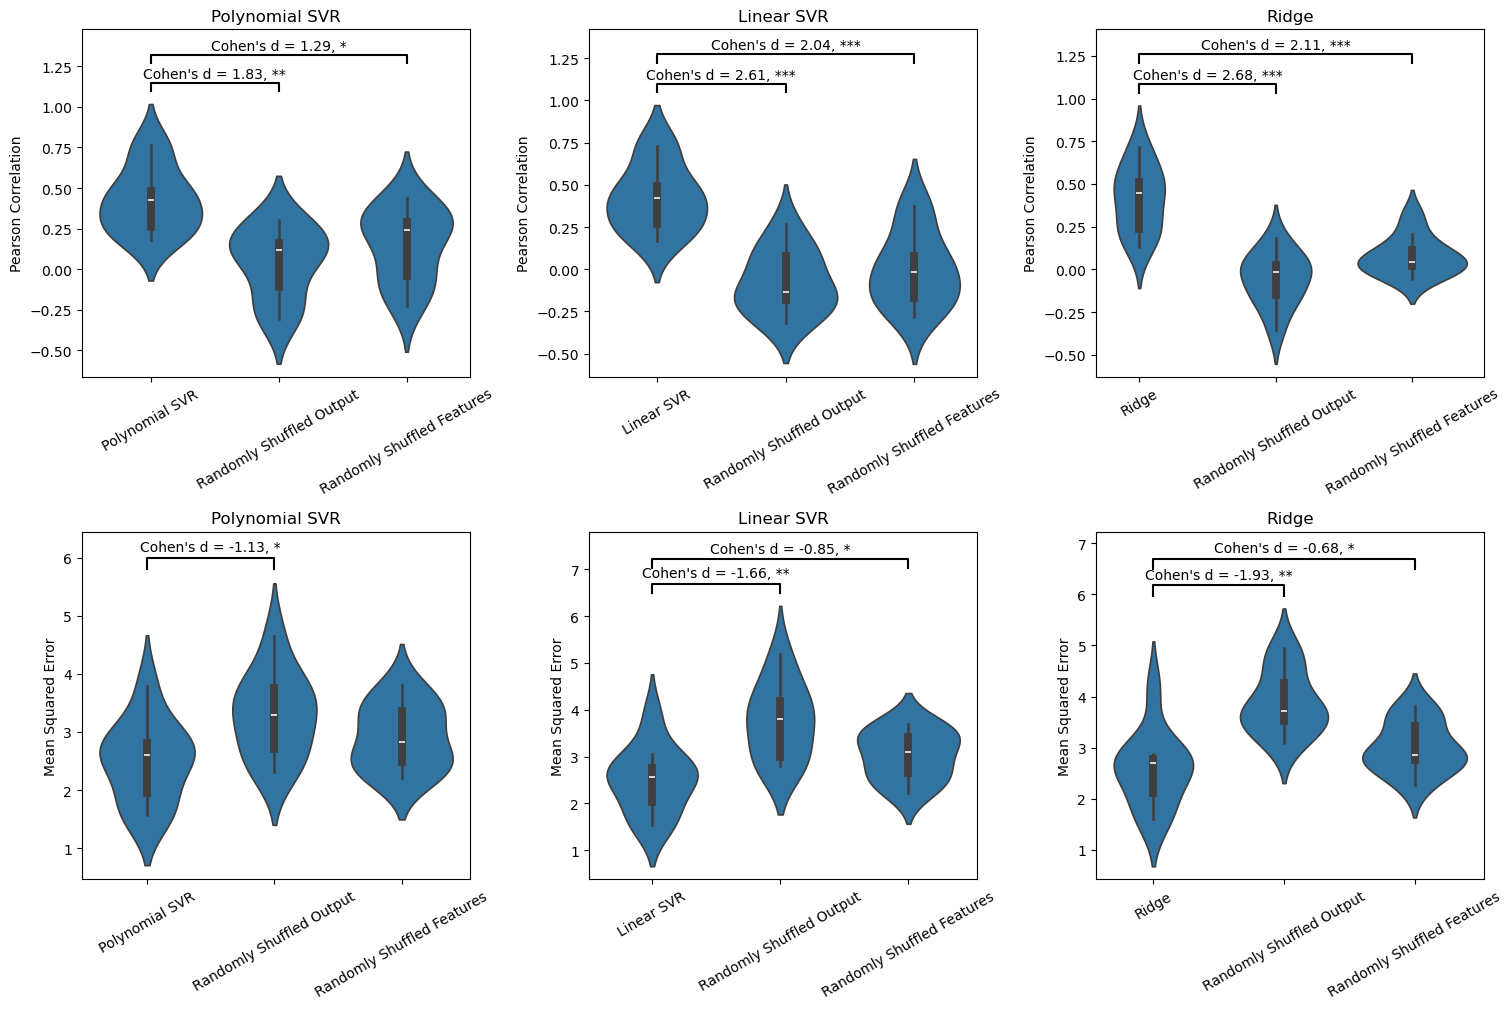

In [23]:
ncols = len(best_pipelines)
nrows = 2 # two metrics
fig, ax = plt.subplots(ncols = ncols, nrows = nrows, figsize = (ncols*5.1, nrows*5.1))

for j, model_type in enumerate(model_order):
#     break
    
    for i, (metric_type, viz_df_) in enumerate(viz_dfs.items()):
        viz_df = viz_df_[[col for col in viz_df_ if model_type in col]]
        viz_df = pd.melt(viz_df, value_name=metric_type, var_name = 'Model Type')

        # some formatting
        viz_df['Model Type'] = viz_df['Model Type'].map({'test_' +mmap[metric_type] + '_' + model_type: model_map[model_type], 
                                  'random_y_test_' +mmap[metric_type] + '_' + model_type: 'Randomly Shuffled Output', 
                                 'random_X_test_' +mmap[metric_type] + '_' + model_type: 'Randomly Shuffled Features'})
        
        # may want to do this across all comparisons simultaneously
        res_stats, mod_combs = get_stats(viz_df, stat_type = 'random', model_type = model_type, metric_type = metric_type)

        sns.violinplot(data = viz_df, x = 'Model Type', y = metric_type, ax = ax[i, j])
        ax[i, j].set_title(model_map[model_type])
        ax[i, j].set_xlabel('')
        
        xlabels = [x._text for x in ax[i, j].get_xticklabels()]
        ax[i, j].set_xticklabels(xlabels, 
                          rotation=30, 
                         ha = 'center')
        
        x_pos = dict(zip(xlabels, ax[i,j].get_xticks()))

        y_lower, y = ax[i,j].get_ylim()
        h = unit_map['h'][metric_type]
        
        # significance
        sig_counter = 0
        for k, (comp1, comp2) in enumerate(mod_combs):#(itertools.combinations(xlabels, 2)):
            x_mid = (x_pos[comp1] + x_pos[comp2]) / 2

            fdr = res_stats[res_stats.comparison == (comp1, comp2)]['fdr'].values[0]
            cd = res_stats[res_stats.comparison == (comp1, comp2)]['cohen_d'].values[0]

            significance = "N.S."
            if fdr <= 1e-4:
                significance = "****"
            elif fdr <= 0.001:
                significance = "***"
            elif fdr <= 0.01:
                significance = "**"
            elif fdr <= 0.1:
                significance = "*"

            if significance != 'N.S.':
    #             y_pos = y+(sig_counter*0.15)
                y_pos = y+(sig_counter*unit_map['y_pos_scale_0'][metric_type])
                ax[i,j].plot([x_pos[comp1], x_pos[comp1], x_pos[comp2], x_pos[comp2]], 
                        [y_pos, y_pos+h, y_pos+h, y_pos], 
                        lw=1.5, c='black')
                y_pos*=unit_map['y_pos_scale'][metric_type]
                ax[i,j].text(x_mid, y_pos + h, f"Cohen's d = {cd:.2f}, " + significance, 
                        ha='center', va='bottom', fontsize=10)
                sig_counter += 1
        if sig_counter != 0:
            ax[i,j].set_ylim(y_lower, y_pos*unit_map['y_max_scale'][metric_type])
fig.tight_layout()
plt.savefig(os.path.join(data_path, 'figures', 'random_proteomics.png'), 
            dpi=300, 
            bbox_inches="tight")  



All models perform better than random for the Pearson Correlation. However, for the MSE, polynomial SVR fails to outperform teh randomly shuffled features. 

### Assessment 2

Next, let's test whether there is a difference in model performance across the consensus models:

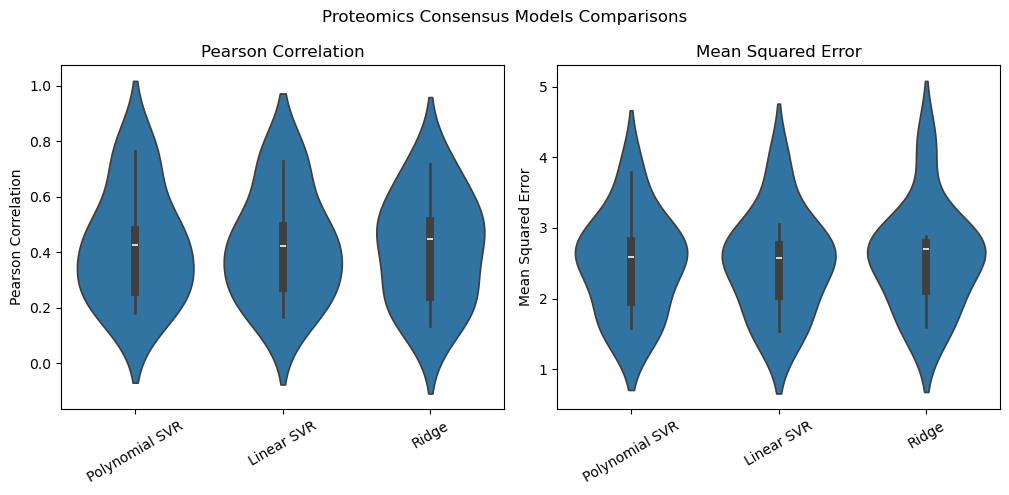

In [24]:
ncols = 2
fig, ax = plt.subplots(ncols = ncols, figsize = (ncols*5.1, 5))

am = {'Pearson Correlation': False, 'Mean Squared Error': True}

for i, (metric_type, viz_df_) in enumerate(viz_dfs.items()):
    viz_df = viz_df_[[col for col in viz_df_ if 'random' not in col]]
    viz_df = pd.melt(viz_df, value_name=metric_type, var_name = 'Model Type')

    # some formatting
    viz_df['Model Type'] = viz_df['Model Type'].map({'test_' +mmap[metric_type] + '_' + model_type: model_map[model_type] for model_type in best_pipelines.keys()})

    
    # may want to do this across all comparisons simultaneously
    res_stats, mod_combs = get_stats(viz_df, stat_type = 'within', 
                                     model_type = None, 
                                     metric_type = None)
    
#     rank_ordered_models = viz_df.groupby(['Model Type']).std()[metric].sort_values(ascending = True).index.tolist()
    viz_df['Ordered Model Type'] = pd.Categorical(viz_df['Model Type'], 
                                          categories = [model_map[m_] for m_ in model_order], 
                                          ordered = True)

    sns.violinplot(data = viz_df, x = 'Ordered Model Type', y = metric_type, ax = ax[i])
    ax[i].set_title(metric_type)
    ax[i].set_xlabel('')

    xlabels = [x._text for x in ax[i].get_xticklabels()]
    ax[i].set_xticklabels(xlabels, 
                      rotation=30, 
                     ha = 'center')

    x_pos = dict(zip(xlabels, ax[i].get_xticks()))

    y_lower, y = ax[i].get_ylim()
    h = unit_map['h'][metric_type]

    # significance
    sig_counter = 0
    for k, (comp1, comp2) in enumerate(mod_combs):#(itertools.combinations(xlabels, 2)):
        x_mid = (x_pos[comp1] + x_pos[comp2]) / 2

        fdr = res_stats[res_stats.comparison == (comp1, comp2)]['fdr'].values[0]
        cd = res_stats[res_stats.comparison == (comp1, comp2)]['cohen_d'].values[0]

        significance = "N.S."
        if fdr <= 1e-4:
            significance = "****"
        elif fdr <= 0.001:
            significance = "***"
        elif fdr <= 0.01:
            significance = "**"
        elif fdr <= 0.1:
            significance = "*"

        if significance != 'N.S.':
#             y_pos = y+(sig_counter*0.15)
            y_pos = y+(sig_counter*unit_map['y_pos_scale_0'][metric_type])
            ax[i].plot([x_pos[comp1], x_pos[comp1], x_pos[comp2], x_pos[comp2]], 
                    [y_pos, y_pos+h, y_pos+h, y_pos], 
                    lw=1.5, c='black')
            y_pos*=unit_map['y_pos_scale'][metric_type]
            ax[i].text(x_mid, y_pos + h, f"Cohen's d = {cd:.2f}, " + significance, 
                    ha='center', va='bottom', fontsize=10)
            sig_counter += 1
    if sig_counter != 0:
        ax[i].set_ylim(y_lower, y_pos*unit_map['y_max_scale'][metric_type])
        
fig.suptitle('Proteomics Consensus Models Comparisons')
fig.tight_layout()

plt.savefig(os.path.join(data_path, 'figures', 'consensus_proteomics.png'), 
            dpi=300, 
            bbox_inches="tight")  


There is no significant difference in consensus model performance by either metric.

### Assessment 3

Finally, let's test whether there is a difference in these model performances vs the consensus model identified in transcriptomics. We use the consensus linear SVR as outlined in [notebook A/03](../A_rna_prediction/03_predict_transcriptomics.ipynb). 

We use the results from the power analysis [A/05 power analysis](../A_rna_prediction/05_power_analysis_transcriptomics.ipynb), selecting the run with the number of samples equal to the number of samples available to proteomics. One caveat here is that the transcriptomic results were note calculated on the same set of folds as proteomics. However, given the bootstrapping of 100 subsets per fold, results should be consistent. 

In [44]:
X = pd.read_csv(os.path.join(data_path, 'processed',  'expr_protein.csv'), index_col = 0).values
y = pd.read_csv(os.path.join(data_path, 'processed', 'metastatic_potential_protein.csv'), index_col = 0)['mean'].values.ravel()

transcriptomics_power = pd.read_csv(os.path.join(data_path, 'processed', 'power_analysis_transcriptomics_linear_svr.csv'), index_col = 0)


In [45]:
print('Mean, median, and std for transcriptomics power analysis:')
for sample_size_ in [y.shape[0] - 1, y.shape[0]]:
    sample_size = int(np.round(sample_size_*(1-(1/n_splits))))
    transcriptomics_res = transcriptomics_power[transcriptomics_power.train_sample_size == sample_size].copy()
    for metric in ['test_mse', 'test_corr']:
        print('Metric: {} | Sample size {} | {:.2f}, {:.2f}, {:.2f}'.format(
            metric.split('_')[1], sample_size, 
            transcriptomics_res[metric].mean(), 
            transcriptomics_res[metric].median(), 
            transcriptomics_res[metric].std()

        ))

Mean, median, and std for transcriptomics power analysis:
Metric: mse | Sample size 222 | 2.09, 2.16, 0.41
Metric: corr | Sample size 222 | 0.43, 0.43, 0.12
Metric: mse | Sample size 223 | 2.10, 2.17, 0.40
Metric: corr | Sample size 223 | 0.42, 0.42, 0.12


In [46]:
print('Mean, median, and std for proteomics linear svr:')

for metric in ['test_mse', 'test_corr']:    
    print('Metric: {} | {:.2f}, {:.2f}, {:.2f}'.format(
        metric.split('_')[1], 
        best_res_df[metric + '_svr_linear'].mean(), 
        best_res_df[metric + '_svr_linear'].median(), 
        best_res_df[metric + '_svr_linear'].std()

    ))

Mean, median, and std for proteomics linear svr:
Metric: mse | 2.51, 2.57, 0.70
Metric: corr | 0.42, 0.42, 0.19


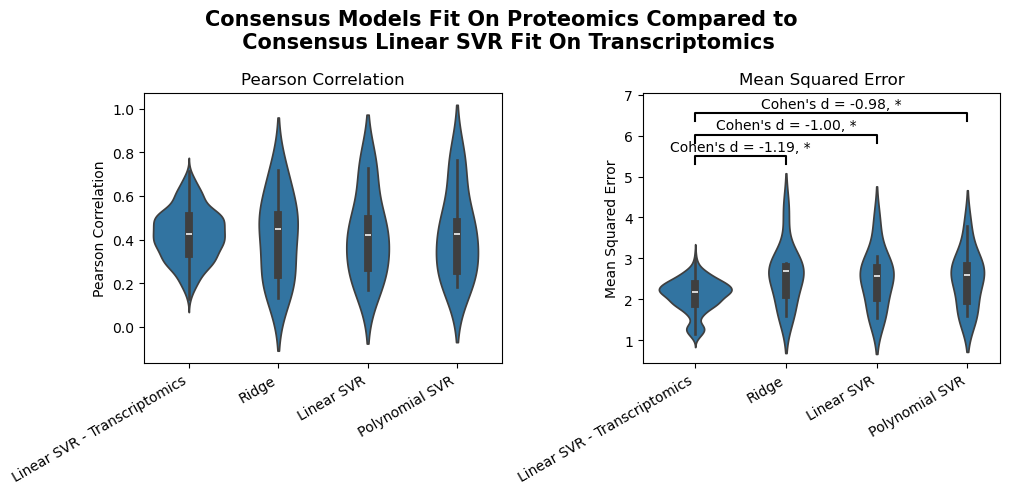

In [53]:
ncols = 2
fig, ax = plt.subplots(ncols = ncols, figsize = (ncols*5.1, 5))

res_stats_all = pd.DataFrame(columns = ['comparison', 'pval', 'cohen_d', 'fdr'])

for i, (metric_type, viz_df_) in enumerate(viz_dfs.items()):
    viz_df = viz_df_[[col for col in viz_df_ if 'random' not in col]]
    viz_df = pd.melt(viz_df, value_name=metric_type, var_name = 'Model Type')

    # some formatting
    viz_df['Model Type'] = viz_df['Model Type'].map({'test_' +mmap[metric_type] + '_' + model_type: model_map[model_type] for model_type in best_pipelines.keys()})

    viz_df_rna = pd.DataFrame(data = {'Model Type': 'Linear SVR - Transcriptomics', 
                                      metric_type: transcriptomics_res['test_' + mmap[metric_type]]}
                             ).reset_index(drop = True)
    viz_df = pd.concat([viz_df_rna, viz_df], axis = 0)
    
    res_stats, mod_combs = get_stats(viz_df, stat_type = 'transcriptomics', 
                                     model_type = None, 
                                     metric_type = metric_type)
    res_stats_ = res_stats.copy()
    res_stats['metric'] = metric_type
    res_stats_all = pd.concat([res_stats_all, res_stats], axis = 0)
    
#     if metric_type == 'Mean Squared Error':
#         cd_print, fdr_print = res_stats[res_stats.comparison == ('Linear SVR - Transcriptomics', 'Polynomial SVR')][['cohen_d', 'fdr']].values.tolist()[0]

#         print(', '.join(['metric: ' + metric_type, 
#                   'comparison: Linear SVR - Transcriptomics^Polynomial SVR', 
#                   'cohend:{:.4f}'.format(cd_print), 
#                   'fdr:{:.4f}'.format(fdr_print)]))

    sns.violinplot(data = viz_df, x = 'Model Type', y = metric_type, ax = ax[i])
    ax[i].set_title(metric_type)
    ax[i].set_xlabel('')

    xlabels = [x._text for x in ax[i].get_xticklabels()]
    ax[i].set_xticklabels(xlabels, 
                      rotation=30, 
                     ha = 'right')

    x_pos = dict(zip(xlabels, ax[i].get_xticks()))

    y_lower, y = ax[i].get_ylim()
    h = unit_map['h'][metric_type]

    # significance
    sig_counter = 0
    for k, (comp1, comp2) in enumerate(mod_combs):#(itertools.combinations(xlabels, 2)):
        x_mid = (x_pos[comp1] + x_pos[comp2]) / 2

        fdr = res_stats[res_stats.comparison == (comp1, comp2)]['fdr'].values[0]
        cd = res_stats[res_stats.comparison == (comp1, comp2)]['cohen_d'].values[0]

        significance = "N.S."
        if fdr <= 1e-4:
            significance = "****"
        elif fdr <= 0.001:
            significance = "***"
        elif fdr <= 0.01:
            significance = "**"
        elif fdr <= 0.1:
            significance = "*"

        if significance != 'N.S.':
#             y_pos = y+(sig_counter*0.15)
            y_pos = y+(sig_counter*unit_map['y_pos_scale_0'][metric_type])
            ax[i].plot([x_pos[comp1], x_pos[comp1], x_pos[comp2], x_pos[comp2]], 
                    [y_pos, y_pos+h, y_pos+h, y_pos], 
                    lw=1.5, c='black')
            y_pos*=unit_map['y_pos_scale'][metric_type]
            ax[i].text(x_mid, y_pos + h, f"Cohen's d = {cd:.2f}, " + significance, 
                    ha='center', va='bottom', fontsize=10)
            sig_counter += 1
    if sig_counter != 0:
        ax[i].set_ylim(y_lower, y_pos*unit_map['y_max_scale'][metric_type])
        
fig.suptitle('Consensus Models Fit On Proteomics Compared to \n Consensus Linear SVR Fit On Transcriptomics', fontweight = 'bold', fontsize = 15)
fig.tight_layout()
plt.savefig(os.path.join(data_path, 'figures', 'consensus_proteomics_comparison.png'), 
            dpi=300, 
            bbox_inches="tight")  

res_stats_all.to_csv(os.path.join(data_path, 'interim', 'proteomics_consensus_comparison_statistics.csv'))


In [49]:
print('Transcriptomics Downsampling: ')
transcriptomics_res[['test_corr', 'test_mse']].median()

Transcriptomics Downsampling: 


test_corr    0.423624
test_mse     2.165500
dtype: float64

In [50]:
print('Proteomics Consensus:')
best_res_df[['test_corr_svr_linear', 'test_mse_svr_linear']].median()

Proteomics Consensus:


test_corr_svr_linear    0.421103
test_mse_svr_linear     2.570995
dtype: float64

In [51]:
res_stats_all

,comparison,pval,cohen_d,fdr,metric
0,"(Linear SVR - Transcriptomics, Ridge)",0.865472,0.083395,0.865472,Pearson Correlation
1,"(Linear SVR - Transcriptomics, Linear SVR)",0.714726,0.003972,0.865472,Pearson Correlation
2,"(Linear SVR - Transcriptomics, Polynomial SVR)",0.655498,-0.009683,0.865472,Pearson Correlation
0,"(Linear SVR - Transcriptomics, Ridge)",0.010216,-1.188025,0.028497,Mean Squared Error
1,"(Linear SVR - Transcriptomics, Linear SVR)",0.024087,-0.999006,0.028497,Mean Squared Error
2,"(Linear SVR - Transcriptomics, Polynomial SVR)",0.028497,-0.982483,0.028497,Mean Squared Error


In [52]:
res_stats_all.loc[1, :]

,comparison,pval,cohen_d,fdr,metric
1,"(Linear SVR - Transcriptomics, Linear SVR)",0.714726,0.003972,0.865472,Pearson Correlation
1,"(Linear SVR - Transcriptomics, Linear SVR)",0.024087,-0.999006,0.028497,Mean Squared Error


While the model performance is the same by correlation, let's check whether the consistency as measured by variance is consistent. Here, we subset transcriptomics power analysis results (1000 "samples") 1000 times to equal the size of proteomics (10 "samples" (folds)), creating a null distribution. Next, we get a p-value testing whether the variance of model performance in proteomics > that of transcriptomics (if p<0.05, alternative = 'greater', reject the null of transcriptomics var = proteomics var).

In [44]:
n_subsets = 1000
N = best_res_df.shape[0]   


bootstrap_idx = [
    np.random.choice(len(transcriptomics_res), size=N, replace=False)
    for _ in range(n_subsets)
]
null_vars = {}  
for metric_type in metric_types_:
    null_metric = transcriptomics_res[metric_type].values 
    vars_for_metric = []
    for idx in bootstrap_idx:
        vars_for_metric.append(null_metric[idx].var(ddof=1))

    null_vars[metric_type] = np.array(vars_for_metric)

var_stats = {'model_type': [], 'metric_type': [], 'pval': []}
for model_type, metric_type in itertools.product(model_types_, metric_types_):

    actual_var = best_res_df[f"{metric_type}_{model_type}"].var(ddof=1)

    # one-sided p-value: actual_var > null
    pval = (null_vars[metric_type] >= actual_var).mean()

    var_stats['model_type'].append(model_type)
    var_stats['metric_type'].append(metric_type)
    var_stats['pval'].append(pval)

var_stats = pd.DataFrame(var_stats)


var_stats['fdr'] = np.nan

for metric_type in metric_types_:
    mask = var_stats['metric_type'] == metric_type
    pvals = var_stats.loc[mask, 'pval'].values
    _, fdr_corr, _, _ = multipletests(pvals, method='fdr_bh')

    var_stats.loc[mask, 'fdr'] = fdr_corr

var_stats = var_stats.sort_values(by = ['metric_type', 'model_type']).reset_index(drop = True)
var_stats

,model_type,metric_type,pval,fdr
0,ridge,test_corr,0.000,0.000
1,svr_linear,test_corr,0.000,0.000
2,svr_poly,test_corr,0.000,0.000
3,ridge,test_mse,0.001,0.002
4,svr_linear,test_mse,0.002,0.002
5,svr_poly,test_mse,0.002,0.002


In [47]:
# fns = [os.path.join(data_path, 'figures', 'consensus_proteomics_comparison.png'), 
#        os.path.join(data_path, 'figures', 'random_proteomics.png'), 
#        os.path.join(data_path, 'processed', 'proteomics_consensus_performance.csv'), 
#        os.path.join(data_path, 'figures', 'all_models_proteomics.png')]

# for fn in fns:
#     cmd = 'scp hmbaghda@orcd-login001.mit.edu:' + fn
#     cmd += ' Downloads/figures/.'
#     print(cmd)